In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error
from scipy import stats

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/electric-motor-temperature/pmsm_temperature_data.csv


In [2]:
data = pd.read_csv('../../kaggle/input/electric-motor-temperature/pmsm_temperature_data.csv')

In [3]:
data.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


1. Load data set
2. Check distributions
3. Build function to drop 20% of values in 30% of columns
4. Build function to implement various iterativeimputer on dataset
5. Plot imputed values against real values
6. Repeat and plot generalized results

In [4]:
data.drop(columns='profile_id', inplace=True)

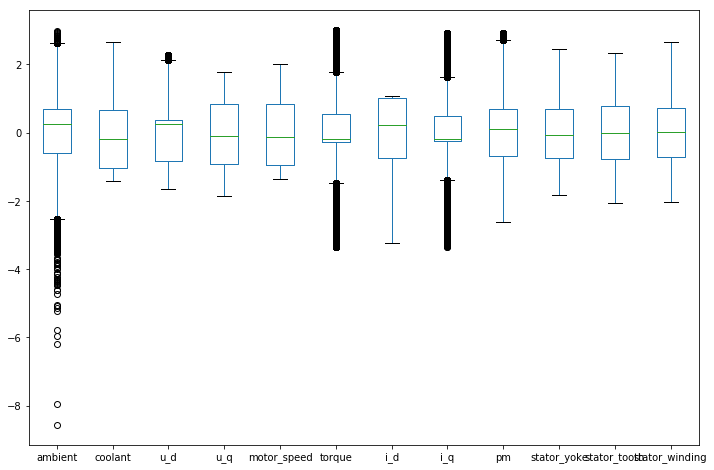

In [5]:
data.boxplot(figsize=(12,8), grid=False)

In [6]:
data.describe()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
count,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000
mean,-0.003905,0.004723,0.004780,-0.005690,-0.006336,-0.003333,0.006043,-0.003194,-0.004396,0.000609,-0.002208,-0.003935
std,0.993127,1.002423,0.997878,1.002330,1.001229,0.997907,0.998994,0.997912,0.995686,1.001049,0.999597,0.998343
min,-8.573954,-1.429349,-1.655373,-1.861463,-1.371529,-3.345953,-3.245874,-3.341639,-2.631991,-1.834688,-2.066143,-2.019973
25%,-0.599385,-1.037925,-0.826359,-0.927390,-0.951892,-0.266917,-0.756296,-0.257269,-0.672308,-0.747265,-0.761951,-0.725622
50%,0.266157,-0.177187,0.267542,-0.099818,-0.140246,-0.187246,0.213935,-0.190076,0.094367,-0.057226,0.005085,0.006536
75%,0.686675,0.650709,0.358491,0.852625,0.853584,0.547171,1.013975,0.499260,0.680691,0.697344,0.772239,0.725660
max,2.967117,2.649032,2.274734,1.793498,2.024164,3.016971,1.060937,2.914185,2.917456,2.449158,2.326668,2.653781


In [7]:
df = data.copy()

In [8]:
def defile_dataset(df, col_selection_rate=0.40):
    cols = np.random.choice(df.columns, int(len(df.columns)*col_selection_rate))
    df_cp = df.copy()
    for col in cols:
        data_drop_rate = np.random.choice(np.arange(0.15, 0.5, 0.02), 1)[0]
        drop_ind = np.random.choice(np.arange(len(df_cp[col])), size=int(len(df_cp[col])*data_drop_rate), replace=False)
        df_cp[col].iloc[drop_ind] = np.nan
    return df_cp, cols

In [9]:
df_mod, cols = defile_dataset(df)

In [10]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 12 columns):
ambient           516527 non-null float64
coolant           998070 non-null float64
u_d               998070 non-null float64
u_q               998070 non-null float64
motor_speed       998070 non-null float64
torque            998070 non-null float64
i_d               998070 non-null float64
i_q               648746 non-null float64
pm                828399 non-null float64
stator_yoke       998070 non-null float64
stator_tooth      998070 non-null float64
stator_winding    998070 non-null float64
dtypes: float64(12)
memory usage: 91.4 MB


In [11]:
imputer = IterativeImputer(sample_posterior=True)
imputer_non = IterativeImputer()

In [12]:
df1 = df_mod.copy()
df2 = df_mod.copy()

In [13]:
df_mod_fit = imputer.fit_transform(df1)

In [14]:
imputer.get_params()

{'add_indicator': False,
 'estimator': None,
 'imputation_order': 'ascending',
 'initial_strategy': 'mean',
 'max_iter': 10,
 'max_value': None,
 'min_value': None,
 'missing_values': nan,
 'n_nearest_features': None,
 'random_state': None,
 'sample_posterior': True,
 'tol': 0.001,
 'verbose': 0}

In [15]:
df_mod_fit_non = imputer_non.fit_transform(df2)

/opt/conda/lib/python3.6/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [16]:
df_mod_fit.shape

(998070, 12)

In [17]:
df_fit_np = df_mod_fit[:,[df.columns.get_loc(i) for i in cols]]

In [18]:
df_fit_non_np = df_mod_fit_non[:,[df.columns.get_loc(i) for i in cols]]

In [19]:
pd.DataFrame(df_fit_non_np, columns=cols)

,ambient,pm,i_q,ambient
0,-1.510699,-2.522071,-0.245860,-1.510699
1,-0.771263,-2.522418,-0.231170,-0.771263
2,-1.506071,-2.522673,-0.237758,-1.506071
3,-0.780935,-2.521639,-0.230302,-0.780935
4,-1.516458,-2.521900,-0.246610,-1.516458
...,...,...,...,...
998065,-0.047497,1.045537,-0.235267,-0.047497
998066,-0.048839,0.429751,-0.245736,-0.048839
998067,-0.042350,1.074434,-0.234864,-0.042350
998068,-0.039433,0.429558,-0.231546,-0.039433


In [20]:
df_np = df[cols].values

In [21]:
print(df_fit_np.shape)
print(df_np.shape)

(998070, 4)
(998070, 4)


In [22]:
for i in range(len(cols)):
    print("When sample posterior is True {:.3f} and when it isnt {:.3f}".format(mean_squared_error(df_np[:,i], df_fit_np[:,i]), mean_squared_error(df_np[:,i], df_fit_non_np[:,i])))

When sample posterior is True 0.599 and when it isnt 0.302
When sample posterior is True 0.082 and when it isnt 0.043
When sample posterior is True 0.003 and when it isnt 0.002
When sample posterior is True 0.599 and when it isnt 0.302


In [23]:
print(np.std(df_np, axis=0))
print(np.std(df_fit_non_np, axis=0))

[0.99312628 0.99568575 0.99791165 0.99312628]
[0.84284381 0.97800331 0.99729188 0.84284381]


In [24]:
print(stats.sem(df_np, axis=0))
print(stats.sem(df_fit_non_np, axis=0))

[0.00099409 0.00099665 0.00099888 0.00099409]
[0.00084366 0.00097895 0.00099826 0.00084366]


In [25]:
def impute(df_orig):
    df_miss, cols = defile_dataset(df_orig)
    df_orig_slice = df_orig[cols]
    imputed_data = []
    n_iterations = []
    for i in range(10):
        imputer = IterativeImputer(max_iter=(i+1)*10)
        df_stg = df_miss.copy()
        imp_arr = imputer.fit_transform(df_stg)
        n_iterations.append(imputer.n_iter_)
        imp_arr_sl = imp_arr[:,[df_orig.columns.get_loc(i) for i in cols]]
        imputed_data.append(pd.DataFrame(imp_arr_sl, columns=cols))
    return df_orig_slice, imputed_data, n_iterations

In [26]:
def impute_once(df_orig):
    df_miss, cols = defile_dataset(df_orig)
    df_orig_slice = df_orig[cols]
    imputer = IterativeImputer(max_iter=100)
    df_stg = df_miss.copy()
    imp_arr = imputer.fit_transform(df_stg)
    return df_orig_slice, df_miss[cols], pd.DataFrame(imp_arr[:,[df_orig.columns.get_loc(i) for i in cols]], columns=cols), imputer.n_iter_

In [27]:
df_orig, imp_data, n_iter = impute(df)

In [28]:
df_orig.head()

,coolant,stator_winding,i_d,u_d
0,-1.118446,-2.018033,1.029572,0.327935
1,-1.117021,-2.017631,1.029509,0.329665
2,-1.116681,-2.017343,1.029448,0.332771
3,-1.116764,-2.017632,1.032845,0.333700
4,-1.116775,-2.018145,1.031807,0.335206


In [29]:
len(imp_data)

10

In [30]:
cols = df_orig.columns

In [31]:
imp_data[0][cols[0]]

0        -1.118446
1        -1.117021
2        -1.030918
3        -1.116764
4        -1.034998
            ...   
998065    0.905269
998066    0.894415
998067    0.869482
998068    0.861070
998069    0.312666
Name: coolant, Length: 998070, dtype: float64

In [32]:
n_iter

[9, 9, 9, 9, 9, 9, 9, 9, 9, 9]

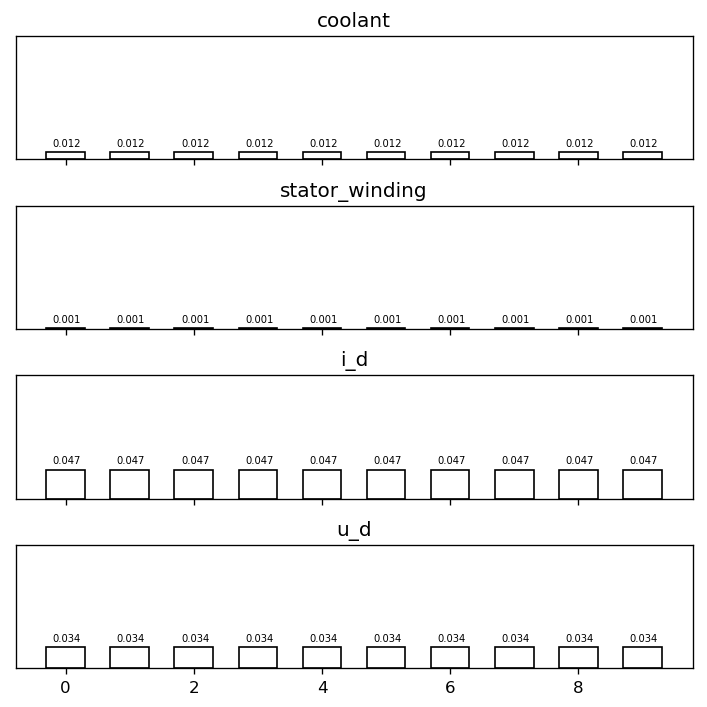

In [33]:
fig, axes = plt.subplots(len(cols), sharex=True, figsize=(6,6), dpi=120)
for i in range(len(cols)):
    bars = []
    for j in range(len(imp_data)):
        bars.append(mean_squared_error(df_orig[cols[i]], imp_data[j][cols[i]])) 
    axes[i].bar(np.arange(10), bars, color='white', width=0.6, edgecolor='k', linewidth=1)
    axes[i].set_ylim([0,0.2])
    axes[i].set_yticks([])
    for k in range(len(imp_data)):
        axes[i].text(k-0.2, bars[k]+0.01, round(bars[k], 3), fontsize=6)
    axes[i].set_title(str(cols[i]))
fig.tight_layout()
plt.show()

In [34]:
'''
fig, axes = plt.subplots(len(cols), sharex=True, figsize=(10,8), dpi=120)
for i in range(len(cols)):
    for j in range(len(imp_data)):
        sns.boxplot(np.arange(10), imp_data[j][cols[i]], ax=axes[i])
    #axes[i].set_ylim([0.8,1.2])
    #axes[i].set_yticks([])
    #for k in range(len(imp_data)):
        #axes[i].text(k-0.2, bars[k]+0.01, round(bars[k], 3), fontsize=6)
    #axes[i].set_title(str(cols[i]))
fig.tight_layout()
plt.show()
'''

'\nfig, axes = plt.subplots(len(cols), sharex=True, figsize=(10,8), dpi=120)\nfor i in range(len(cols)):\n    for j in range(len(imp_data)):\n        sns.boxplot(np.arange(10), imp_data[j][cols[i]], ax=axes[i])\n    #axes[i].set_ylim([0.8,1.2])\n    #axes[i].set_yticks([])\n    #for k in range(len(imp_data)):\n        #axes[i].text(k-0.2, bars[k]+0.01, round(bars[k], 3), fontsize=6)\n    #axes[i].set_title(str(cols[i]))\nfig.tight_layout()\nplt.show()\n'

In [35]:
pd.DataFrame(imp_data[0].stack()).reset_index()

,level_0,level_1,0
0,0,coolant,-1.118446
1,0,stator_winding,-2.045265
2,0,i_d,1.029572
3,0,u_d,0.327935
4,1,coolant,-1.117021
...,...,...,...
3992275,998068,u_d,0.152994
3992276,998069,coolant,0.312666
3992277,998069,stator_winding,0.489382
3992278,998069,i_d,1.029141


In [36]:
df_og, df_def, df_imp, n_iter = impute_once(df)

In [37]:
print(df_og.columns)
print(df_imp.columns)
print(n_iter)

Index(['pm', 'stator_yoke', 'torque', 'ambient'], dtype='object')
Index(['pm', 'stator_yoke', 'torque', 'ambient'], dtype='object')
8


In [38]:
for i in range(len(df_og.columns)):
    print("Iterative Imputer: MSE for {} is {:.4f}.".format(df_og.columns[i], mean_squared_error(df_og[df_og.columns[i]], df_imp[df_imp.columns[i]])))

Iterative Imputer: MSE for pm is 0.0950.
Iterative Imputer: MSE for stator_yoke is 0.0004.
Iterative Imputer: MSE for torque is 0.0012.
Iterative Imputer: MSE for ambient is 0.2057.


In [39]:
df_def = df_def[df_og.columns]

In [40]:
from sklearn.impute import SimpleImputer

In [41]:
sim_imp = SimpleImputer()

In [42]:
df_simimp = pd.DataFrame(sim_imp.fit_transform(df_def), columns=df_og.columns)

In [43]:
for i in range(len(df_og.columns)):
    print("Simple Imputer: MSE for {} is {:.4f}.".format(df_og.columns[i], mean_squared_error(df_og[df_og.columns[i]], df_simimp[df_simimp.columns[i]])))

Simple Imputer: MSE for pm is 0.3869.
Simple Imputer: MSE for stator_yoke is 0.1501.
Simple Imputer: MSE for torque is 0.3282.
Simple Imputer: MSE for ambient is 0.3048.
